# LAT Workshop Tutorial #1: Sensitivity Curves, SNR, Inner Products, Likelihoods

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from lisatools.utils.constants import *
from copy import deepcopy  # can be useful

In the first tutorial, we will learn how to use `lisatools` to generate sensitivity curves for LISA. With this information, we will then compute inner products, signal-to-noise ratios (SNR), and Likelihoods for a basic set of sources. 

## Task 1: Plotting and comparing sensitivity curves.

Calculate and plot the **sky-averaged** LISA sensitivity function in the characteristic strain representation. Compare the **model** used for the LDC2A (or Sangria) dataset to the Science Requirements Document version for the sensitivity curves (`scirdv1`).

Useful documentation:
* [get_available_default_lisa_models](https://mikekatz04.github.io/LISAanalysistools/build/html/user/main.html#lisatools.detector.get_available_default_lisa_models)
* [get_stock_sensitivity_options](https://mikekatz04.github.io/LISAanalysistools/build/html/user/sensitivity.html#lisatools.sensitivity.get_stock_sensitivity_options)
* [get_sensitivity](https://mikekatz04.github.io/LISAanalysistools/build/html/user/sensitivity.html#lisatools.sensitivity.get_sensitivity)
* [LISASens](https://mikekatz04.github.io/LISAanalysistools/build/html/user/sensitivity.html#lisatools.sensitivity.LISASens)

In [2]:
# useful imports
from lisatools.sensitivity import LISASens, get_sensitivity, get_stock_sensitivity_options
import lisatools.detector as lisa_models

In [7]:
lisa_models.sangria

LISAModel(Soms_d=9.999999999999999e-23, Sa_a=5.76e-30, name=<lisatools.detector.DefaultOrbits object at 0x113c976e0>, orbits='sangria')

In [5]:
get_stock_sensitivity_options()

['X1TDISens',
 'Y1TDISens',
 'Z1TDISens',
 'XY1TDISens',
 'YZ1TDISens',
 'ZX1TDISens',
 'A1TDISens',
 'E1TDISens',
 'T1TDISens',
 'X2TDISens',
 'Y2TDISens',
 'Z2TDISens',
 'LISASens',
 'CornishLISASens',
 'FlatPSDFunction']

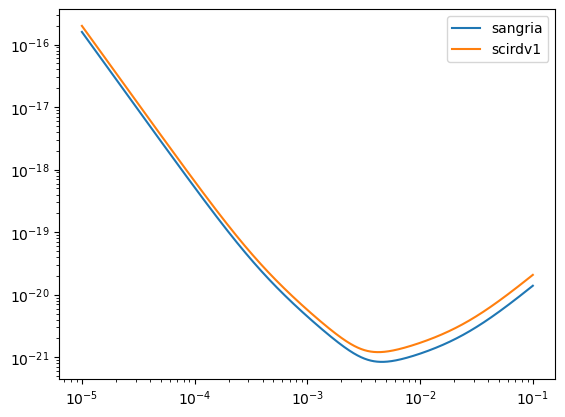

In [16]:
f = np.logspace(-5, -1, 10000)
Sn = get_sensitivity(f, sens_fn=LISASens, return_type='char_strain', average=True, model=lisa_models.sangria)
plt.loglog(f, Sn, label="sangria")

Sn = get_sensitivity(f, sens_fn=LISASens, return_type='char_strain', average=True, model=lisa_models.scirdv1)
plt.loglog(f, Sn, label="scirdv1")
plt.legend()

### Question 1

How do you expect the difference in sensitivity curve models to affect LISA observations? Consider what higher noise at lower or high frequencies will do to our different source classes. 

### Question 2

We have asked you to compute the sky-averaged sensitivity curves. What does that mean? Can you determine, without looking at the documentation what the total sky-averaging factor is?

In [17]:
Sn_av = get_sensitivity(f, sens_fn=LISASens, return_type='char_strain', average=True, model=lisa_models.scirdv1)
Sn_not_av = get_sensitivity(f, sens_fn=LISASens, return_type='char_strain', average=False, model=lisa_models.scirdv1)
print(Sn_av / Sn_not_av)

[2.5819889 2.5819889 2.5819889 ... 2.5819889 2.5819889 2.5819889]


Now we are going to put our sensitivity information into a [SensitivityMatrix](https://mikekatz04.github.io/LISAanalysistools/build/html/user/sensitivity.html#lisatools.sensitivity.SensitivityMatrix). Build a two-channel (with no cross-channels) sensitivity matrix where both channels' sensitivity are governed by the [LISASens](https://mikekatz04.github.io/LISAanalysistools/build/html/user/sensitivity.html#lisatools.sensitivity.LISASens) sensitivituy function.

Useful documentation:
* [SensitivityMatrix](https://mikekatz04.github.io/LISAanalysistools/build/html/user/sensitivity.html#lisatools.sensitivity.SensitivityMatrix)

We will add one extra useful piece of information into here: an estimated Galactic foreground noise to include in the sensitivity. This is important when performing LISA data analysis.

The default foreground function is [FittedHyperbolicTangentGalacticForeground](https://mikekatz04.github.io/LISAanalysistools/build/html/user/stochastic.html#lisatools.stochastic.FittedHyperbolicTangentGalacticForeground). It takes one parameter: observation time in seconds. Use the documentation of the sensitivity function and the stochastic function to determine how to pass this information with the abstracted setup in `lisatools`. 

Useful documentation:
* [LISASens](https://mikekatz04.github.io/LISAanalysistools/build/html/user/sensitivity.html#lisatools.sensitivity.LISASens)
* [FittedHyperbolicTangentGalacticForeground](https://mikekatz04.github.io/LISAanalysistools/build/html/user/stochastic.html#lisatools.stochastic.FittedHyperbolicTangentGalacticForeground)

In [19]:
from lisatools.sensitivity import SensitivityMatrix, LISASens

In [21]:
sens_mat = [LISASens, LISASens]
SensitivityMatrix(f, sens_mat, average=False, T=YRSID_SI, model=lisa_models.scirdv1)

TypeError: Sensitivity.get_stochastic_contribution() got an unexpected keyword argument 'T'

Plot it with the [loglog](https://mikekatz04.github.io/LISAanalysistools/build/html/user/sensitivity.html#lisatools.sensitivity.SensitivityMatrix.loglog) method of the matrix.

Compare the noise curve with and without foreground confusion noise. And then compare the foreground noise at two different values of the observation time. 

Useful documentation:
* [update_stochastic](https://mikekatz04.github.io/LISAanalysistools/build/html/user/sensitivity.html#lisatools.sensitivity.SensitivityMatrix.update_stochastic)

### Question

Why does the foreground confusion change over time? What are the broader implications of this on our analysis?

### Task 2: Build a DataResArray to house and plot data information.

We are going to build a sinusoidal signal for us to do some computations with. We will store it in a [DataResArray](https://mikekatz04.github.io/LISAanalysistools/build/html/user/datacontainer.html#lisatools.datacontainer.DataResidualArray). Build a sinusoidal signal with 4 parameters: $A$ (amplitude), $f_0$ (frequency), $\dot{f}_0$ (frequency derivative), and $\phi_0$ (initial phase):

$$ h_1(t) = A\sin{\left(2\pi (f_0 t + \frac{1}{2}\dot{f}_0t^2) + \phi_0\right)} $$
$$ h_2(t) = A\cos{\left(2\pi (f_0 t + \frac{1}{2}\dot{f}_0t^2) + \phi_0\right)} $$

Pick your parameters. Use a reasonable timestep ($\sim10$s) and observation time ($\sim$yr) for LISA. Plot $h_1$ and $h_2$. 

In [ ]:
dt = 10.0
Tobs = YRSID_SI
Nobs = int(Tobs / dt)
t = np.arange(Nobs) * dt

Now we will add our two channels (h1, h2) into a `DataResArray`. 

Useful Documentation:
* [DataResidualArray](https://mikekatz04.github.io/LISAanalysistools/build/html/user/datacontainer.html#lisatools.datacontainer.DataResidualArray)

In [ ]:
# useful imports
from lisatools.datacontainer import DataResidualArray

Plot the signals with the data residual array plotting functions.

Useful documentation:
* [loglog](https://mikekatz04.github.io/LISAanalysistools/build/html/user/datacontainer.html#lisatools.datacontainer.DataResidualArray.loglog)

### Question 3

When you put in the time-domain signal from above, the `DataResidualArray` class transforms it under the hood. Looking at the output from above, what transform did it do?

Let's take the FFT of our input time-domain dataset with numpy (`np.fft.rfft`) and add this to the above plot. 

What is the factor difference between the FFT we did and the frequency-domain spectra stored in our `DataResidualArray`? Where does this term come frome and why is it there? (this is a small detail that is always easy to forget)

## Task 3: Combine into an `AnalysisContainer`.

Now we will use our data and sensitivity information and combine it into an [AnalysisContainer](https://mikekatz04.github.io/LISAanalysistools/build/html/user/datacontainer.html#analysis-container) object. This object helps streamline the analysis by working under the hood properly with different data and sensitivity matrices.

Plot the new setup with both the data and sensitivity information. We will do computations with this object a little later. 

Helpful documentation:
* [AnalysisContainer](https://mikekatz04.github.io/LISAanalysistools/build/html/user/datacontainer.html#analysis-container)
* [AnalysisContainer.loglog](https://mikekatz04.github.io/LISAanalysistools/build/html/user/datacontainer.html#lisatools.analysiscontainer.AnalysisContainer.loglog)

In [ ]:
from lisatools.analysiscontainer import AnalysisContainer

## Task 4: Compute the inner product.

Now we will inject a signal into the data and calculate the inner product of another signal with that data. We will take `data_res_arr` as the data input. 

Generate a new signal witih a slightly different set of parameters from the injection you chose above. 

### Question:

What is the inner product value of your new signal with the injected data? With numpy calculate the inner product using this equation:

$$ \langle h_1 | h_2 \rangle = 4 \text{Re} \int_{f_\text{min}}^{f_\text{max}}\frac{\tilde{h}_1(f)^*\tilde{h}_2(f)}{S_n(f)}df \ \ .$$


Now, calculate the inner product using the [inner_product](https://mikekatz04.github.io/LISAanalysistools/build/html/user/datacontainer.html#lisatools.analysiscontainer.AnalysisContainer.inner_product) method in the `AnalysisContainer` class. 

The numbers may not match exactly. Under the hood, the inner product function in `lisatools` uses `np.trapz`. If you do a sum, you may get a very small and negligible difference.

Play around with the parameters you chose above. Try to understand how the inner product changes with the parameters you choose (i.e. how far they are from the injection parameters). 

## Task 4: Compute the signal-to-noise ratio.

There are two signal-to-noise ratios (SNR) that are of interest to LISA folks. One is the optimal SNR ($\rho_\text{opt}$) of a template. This is the maximal SNR a template can possible achieve with a given noise profile ($h$ is the template):
$$ \rho_\text{opt} = \sqrt{\langle h | h \rangle}\ \ .  $$
In other words, if the injection data is exactly equivalent to the template, it will achieve this SNR. 

Another SNR of interest is the detected snr ($\rho_\text{det}$). It is given by,
$$ \rho_\text{det} = \frac{\langle d | h \rangle}{\sqrt{\langle h | h \rangle}} = \frac{\langle d | h \rangle}{\rho_\text{opt}}\ \ .  $$

Above, you calcualted $\langle d | h \rangle$, now calculate $\langle h | h \rangle$ with numpy array operations and compute the optimal and detected SNR.

To compute these values with the `AnalysisContainer` object, use the [template_snr](https://mikekatz04.github.io/LISAanalysistools/build/html/user/datacontainer.html#lisatools.analysiscontainer.AnalysisContainer.template_snr) method.

### Question

How does changing the parameters of your template affect the optimal SNR and the detected SNR?

## Task 5: Compute the Likelihood. 

The Likelihood used in LISA (and other areas of GWs) is a Gaussian likelihood that replaces the typical $\frac{x - \mu}{\sigma}$ term with the noise-weighted inner product of the residual data with itself: $\langle \vec{d} - \vec{h} | \vec{d} - \vec{h} \rangle$. Let's break that down. 

1) What do we mean when we say residual? It is the difference between the data and the template.

$$ \vec{r} = \vec{d} - \vec{h} $$

Calculate the residual of the data and the template and store it in a new `DataResidualArray`.

2) Calculate the inner product of the residual with itself. Hint: You can put it in a new `AnalysisContainer` and calculate it directly with that. 

3) Build the full Likelihood. The Gaussian likelihood is given by,
$$ \mathcal{L} = e^{-\frac{1}{2}\langle \vec{d} - \vec{h} | \vec{d} - \vec{h} \rangle} \ \ . $$

We usually work with the natural log of the Likelihood:
$$ \ln{\mathcal{L}} = -\frac{1}{2}\langle \vec{d} - \vec{h} | \vec{d} - \vec{h} \rangle \ \ . $$

With this in mind. Take you inner product value from above and calculate the Likelihood of this template. 

We can also break apart the inner product into usual pieces because the inner product is a linear operation:
$$ \ln{\mathcal{L}} = -\frac{1}{2}\left(\langle \vec{d} | \vec{d}\rangle + \langle \vec{h} | \vec{h}\rangle - 2 \langle \vec{d} | \vec{h}\rangle\right) \ \ . $$

You should see some familiar terms emerging:
* $\langle \vec{h} | \vec{h}\rangle = \rho_\text{opt}^2$
* $\langle \vec{d} | \vec{h}\rangle \sim \rho_\text{det} * \rho_\text{opt}$ (when phase maximized)
* $\langle \vec{d} | \vec{d}\rangle$ is the inner product of the data with itself. In MCMC analysis generally, the $\langle \vec{d} | \vec{d}\rangle$ term will remain constant throughout sampling.

You can calculate the Likelihood of a template against the data using the [template_likelihood](https://mikekatz04.github.io/LISAanalysistools/build/html/user/datacontainer.html#lisatools.analysiscontainer.AnalysisContainer.template_likelihood) method in the `AnalysisContainer` class. 

### Question:


How does changing the parameters effect the Likelihood? How does that relate the optimal and detected SNR values? There are two interesting keyword arguments in the [template_likelihood](https://mikekatz04.github.io/LISAanalysistools/build/html/user/datacontainer.html#lisatools.analysiscontainer.AnalysisContainer.template_snr) method: `include_psd_info` and `phase_maximize`. The `phase_maximize` argument can be found for both the Likelihood and SNR computations. Reading the documentation and adding those keyword arguments in, can you figure out what they are doing with these calculations?

## Task 6: Add a signal model. 

Now we will add a signal model to our Likelihood class. You can either set it as a keyword argument when instantiating the `AnalysisContainer`. Or you can just set it as an attribute after the fact. 

But first, we need to turn our sinusoidal signal into a function. Build a function that takes our four parameters ($A$, $f_0$, $\dot{f}_0$, and $\phi_0$) and returns a list of `[h1, h2]`. Add the time array as an argument to your generator. So it should have a signature like: `sinusoidal_waveform(A: float, f0: float, fdot0: float, phi0: float, t_arr: np.ndarray)`

Now add the signal model to our Likelihood class by updating the `signal_gen` attribute. 

Calculate the Likelihood with a new set of parameters. Remember to add `t` as a last argument to your inputs.

Helpful documentation:
* [AnalysisContainer.calculate_signal_likelihood](https://mikekatz04.github.io/LISAanalysistools/build/html/user/datacontainer.html#lisatools.analysiscontainer.AnalysisContainer.calculate_signal_likelihood)

## Extra practice

 Now repeat various parts of the tutorial adjusting the signal or the sensitivity model. Observe how that changes the inner product, SNR, and Likelihood. Having an understanding of these elements is crucial to LISA data analysis!